# Tugas 3 Kecerdasan Buatan
<p>
    Airlangga Rasyad Fidiyanto<br>
    19/443562/TK/48758
</p>

## 1. Load Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Disable TensorFlow's warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Membaca dan Membersihkan Dataset
Terdapat tiga buah label pada dataset ini, yaitu
<ul>
    <li><code>0</code> untuk teks yang bersifat normal</li>
    <li><code>1</code> untuk teks yang bersifat penipuan atau _fraud_</li>
    <li><code>2</code> untuk teks yang bersifat spam</li>
</ul>

### 2.1 Read CSV File

In [2]:
df = pd.read_csv('./dataset/dataset_sms_indonesia.csv')
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


### 2.2 Data Cleansing dan _Train Test Split_
<p>Karena label <code>2</code> dan <code>1</code> memiliki makna yang sama, maka kedua <code>label</code> tersebut dapat disatukan sebagai spam atau penipuan</p>

In [3]:
df['label'] = df['label'].replace([2], 1)
df.label.value_counts()

1    574
0    569
Name: label, dtype: int64

In [4]:
train_X, test_X, train_y, test_y = train_test_split(df.Teks, 
                                                    df.label, 
                                                    test_size=0.33,
                                                   )

# 3. Membangun Model

### 3.1 Tokenizing dan Padding

In [5]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_X)

train_X_emb = tokenizer.texts_to_sequences(train_X)
test_X_emb = tokenizer.texts_to_sequences(test_X)

vocab_size = len(tokenizer.word_index) + 1

print(f"Tokenized: \n{train_X_emb[1]}")

Tokenized: 
[721, 12, 1484, 1485, 13, 1486]


In [6]:
maxlen = 100

train_X_padded = pad_sequences(train_X_emb, padding='post', maxlen=maxlen)
test_X_padded = pad_sequences(test_X_emb, padding='post', maxlen=maxlen)

print(train_X_padded[1, :])

[ 721   12 1484 1485   13 1486    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### 3.2 Model

In [7]:
embedding_dim = 50

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.GlobalMaxPool1D())
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          191550    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 193,215
Trainable params: 193,215
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(
    train_X_padded, train_y,
    epochs=15,
    validation_data=(test_X_padded, test_y),
    batch_size=16
)

Epoch 1/15
48/48 [==============================] - 2s 28ms/step - loss: 0.6809 - acc: 0.7725 - val_loss: 0.6574 - val_acc: 0.9365
Epoch 2/15
48/48 [==============================] - 1s 18ms/step - loss: 0.6009 - acc: 0.9778 - val_loss: 0.5359 - val_acc: 0.9524
Epoch 3/15
48/48 [==============================] - 1s 16ms/step - loss: 0.3855 - acc: 0.9791 - val_loss: 0.3114 - val_acc: 0.9497
Epoch 4/15
48/48 [==============================] - 1s 17ms/step - loss: 0.1600 - acc: 0.9843 - val_loss: 0.1818 - val_acc: 0.9524
Epoch 5/15
48/48 [==============================] - 1s 14ms/step - loss: 0.0669 - acc: 0.9908 - val_loss: 0.1423 - val_acc: 0.9524
Epoch 6/15
48/48 [==============================] - 1s 16ms/step - loss: 0.0338 - acc: 0.9974 - val_loss: 0.1275 - val_acc: 0.9524
Epoch 7/15
48/48 [==============================] - 1s 17ms/step - loss: 0.0190 - acc: 1.0000 - val_loss: 0.1195 - val_acc: 0.9524
Epoch 8/15
48/48 [==============================] - 1s 14ms/step - loss: 0.0118 - a

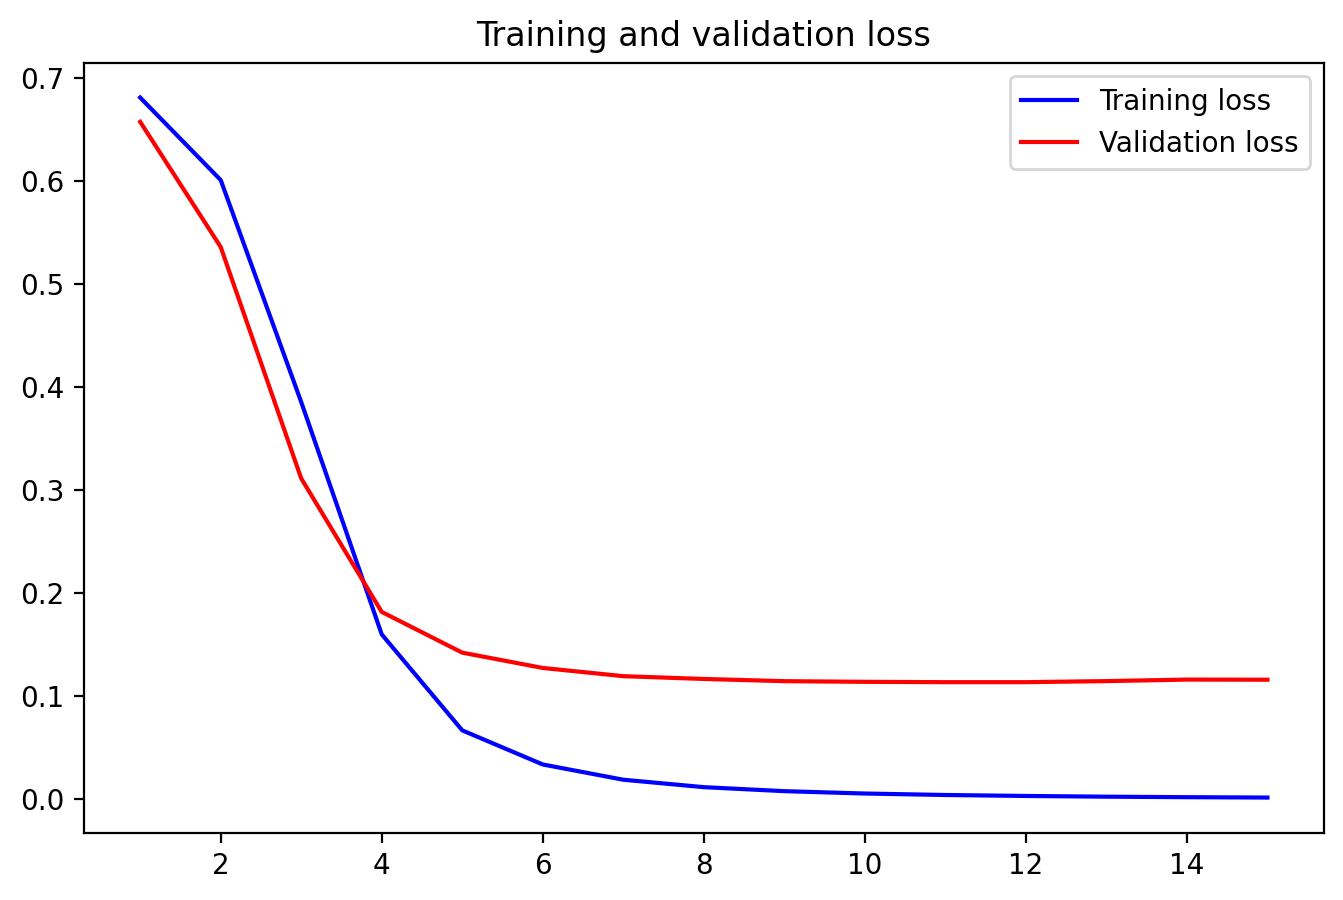

In [9]:
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [10]:
def predict_text(text_to_predict, debug=True):
    prediction = []
    
    tokenized_text_to_predict = tokenizer.texts_to_sequences(text_to_predict)
    padded_text_to_predict = pad_sequences(tokenized_text_to_predict, padding='post', maxlen=maxlen)
    
    model_result = model.predict(padded_text_to_predict)
    
    for mr in model_result:
        if mr > 0.5:
            prediction.append(1)
            if debug: print("Spam")
        else:
            prediction.append(0)
            if debug: print("Normal")
            
    return prediction

## 4. Model Report

In [11]:
print(classification_report(predict_text(test_X, debug=False), test_y))

12/12 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       173
           1       0.96      0.93      0.95       205

    accuracy                           0.94       378
   macro avg       0.94      0.95      0.94       378
weighted avg       0.95      0.94      0.94       378



## 5. Create Prediction

In [12]:
to_predict = [
    '''
    Hallo Bebeb TIFFANY,Pengen Dapatin KAWASAKI KLX 250 * & *IPHONE 14 PROMAX Yang Dibagikan Setiap Hari? 😍😍
    DI AGEN RESMI PIALA DUNIA 2022 MBC303 LAGI BAGI BAGI KAWASAKI KLX 250 * & *IPHONE 14 PROMAX DISINI : SPINMBCHOKI.ORG
    Caranya Gampang Banget Lho Kesayangan TIFFANY !!!

    Buat Yang Pengen Langsung Kesini Aja Deh Yah Kakak Sayang

    magic.ly/kaorusadikun
    WA Info *KAWASAKI KLX 250 & IPHONE 14 PROMAX : wa.me/6281905011286
    LINK DAPET KAWASAKI KLX 250 & IPHONE 14 PROMAX GESS : mbcgacor.com
    '''
]

predict_text(to_predict)

1/1 [==============================] - 0s 50ms/step
Spam


[1]

In [13]:
to_predict = [
    '''
    Sy tunggu di ruangan saya besok untuk rapat degan kementerian.
    '''
]

predict_text(to_predict)

1/1 [==============================] - 0s 12ms/step
Normal


[0]